In [1]:
model_type = ['powerlaw', 'composite'][0]
num_total_samples = 49000 # better if multiple of 7

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import glob

files = sorted(glob.glob('../lens_model_chain/{}/RXJ1131*mc*'.format(model_type)))

files

['../lens_model_chain/powerlaw/RXJ1131_Mcmc117_EsrGlight.mcmc.txt',
 '../lens_model_chain/powerlaw/RXJ1131_Mcmc121_EsrGlight.mcmc.txt',
 '../lens_model_chain/powerlaw/RXJ1131_Mcmc122_EsrGlight.mcmc.txt',
 '../lens_model_chain/powerlaw/RXJ1131_Mcmc123_EsrGlight.mcmc.txt',
 '../lens_model_chain/powerlaw/RXJ1131_Mcmc124_EsrGlight.mcmc.txt',
 '../lens_model_chain/powerlaw/RXJ1131_Mcmc125_EsrGlight.mcmc.txt',
 '../lens_model_chain/powerlaw/RXJ1131_Mcmc126_EsrGlight.mcmc.txt']

In [4]:
chain_0 = np.loadtxt(files[0])

In [5]:
chain_0.shape

(53895, 28)

## Sample from the chain using weight column

Chain: ../lens_model_chain/powerlaw/RXJ1131_Mcmc117_EsrGlight.mcmc.txt
Number of samples after burnin: 43895


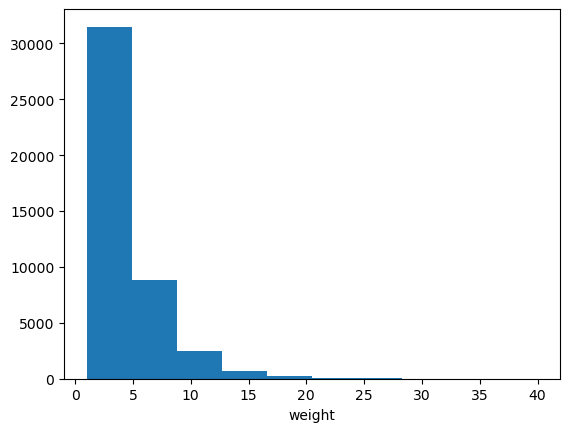

Chain: ../lens_model_chain/powerlaw/RXJ1131_Mcmc121_EsrGlight.mcmc.txt
Number of samples after burnin: 41319


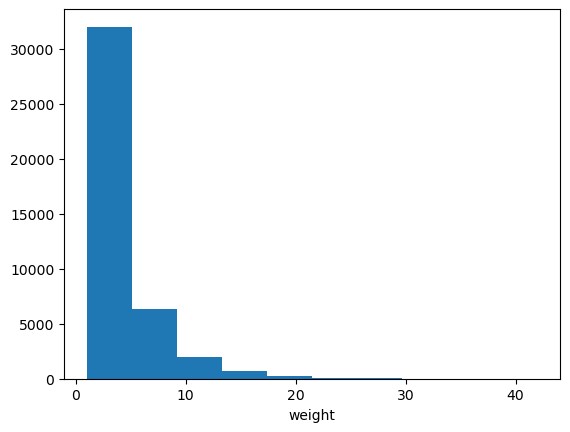

Chain: ../lens_model_chain/powerlaw/RXJ1131_Mcmc122_EsrGlight.mcmc.txt
Number of samples after burnin: 43212


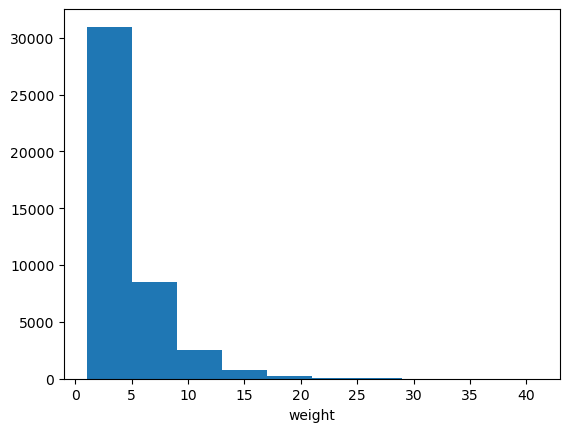

Chain: ../lens_model_chain/powerlaw/RXJ1131_Mcmc123_EsrGlight.mcmc.txt
Number of samples after burnin: 37688


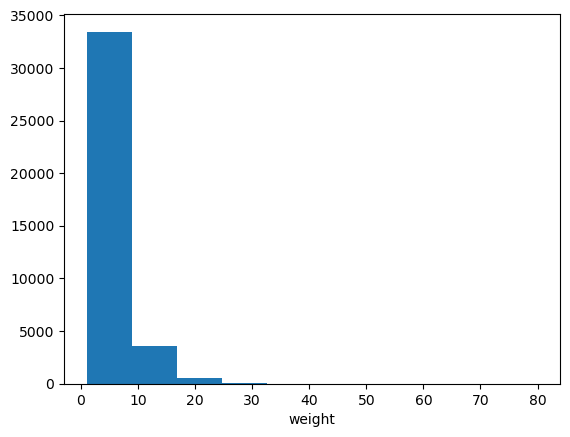

Chain: ../lens_model_chain/powerlaw/RXJ1131_Mcmc124_EsrGlight.mcmc.txt
Number of samples after burnin: 34147


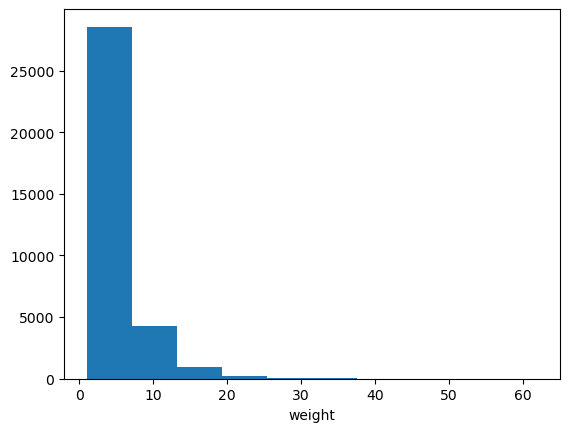

Chain: ../lens_model_chain/powerlaw/RXJ1131_Mcmc125_EsrGlight.mcmc.txt
Number of samples after burnin: 26052


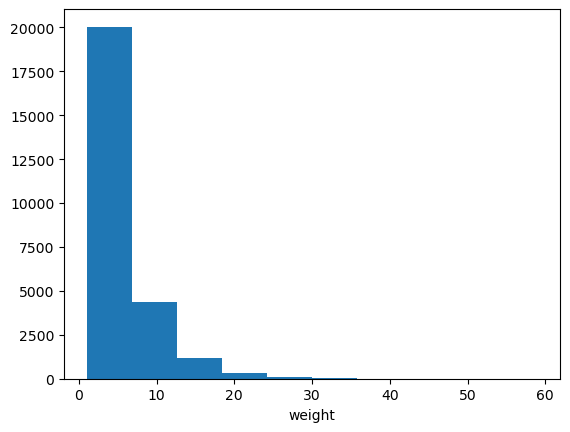

Chain: ../lens_model_chain/powerlaw/RXJ1131_Mcmc126_EsrGlight.mcmc.txt
Number of samples after burnin: 20685


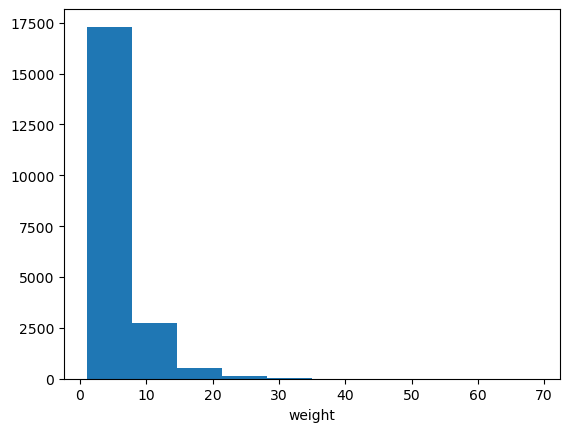

In [6]:
 
for i, f in enumerate(files):
    if model_type == 'powerlaw':
        chain_id = int(files[0][32:35])

        if chain_id == 117:                                                                                                           
            burnin = 25000
        elif chain_id == 124:                                                                                                         
            chain_id = 2000                                                                                                       
        elif chain_id ==125:                                                                                                          
            burnin = 2000                                                                                                       
        else:                                                                                                                   
            burnin = 10000
    else:
        burnin = 2000
        
    #size = 15000
    chain = np.loadtxt(f)
    chain = chain[burnin:, :]
    
    weight = chain[:, 6]
    
    print('Chain: {}'.format(f))
    print('Number of samples after burnin: {}'.format(chain.shape[0]))

    
    plt.hist(weight)
    plt.xlabel('weight')
    plt.show()
        
    
    
    if model_type == 'powerlaw':
        # param_indices = [11, 12, 9, 10, 16]
        param_indices = [11, 12, 9, 16]
        # theta_E, gamma, q, PA, D_Dt(Mpc)
    elif model_type == 'composite':
        # param_indices = [11, 12, 16, 9, 10, 17]
        param_indices = [11, 12, 16, 9, 17]
        # theta_e=4*kappa_s, r_scale, M/L, b/a (=q), PA, D_Dt(Mpc)
    
    
    
    sampled_indices = np.random.choice(np.arange(chain.shape[0]), p=weight/np.sum(weight), 
                                       size=int(num_total_samples/len(files)), 
                                       replace=True)
    
    if i == 0:
        master_chain = chain[sampled_indices, :][:, param_indices]
    else:
        master_chain = np.append(master_chain, chain[sampled_indices, :][:, param_indices], axis=0)
        
    #print(chain.shape, master_chain.shape)

if model_type == 'powerlaw':
    eta = master_chain[:, 1]
    gamma = 2 * eta + 1
    q = master_chain[:, 2] 
    R_E = master_chain[:, 0]
    
    master_chain[:, 1] = gamma
    # master_chain[:, 3] = 180*master_chain[:, 3]/np.pi - 90
    master_chain[:, 0] = R_E * (2. / (1. + q)) ** ( 1. / (gamma - 1.)) * np.sqrt(q)
elif model_type == 'composite':
    master_chain[:, 0] /= 4
    # master_chain[:, 4] = 180*master_chain[:, 4]/np.pi - 90
    

    

In [7]:
if model_type == 'powerlaw':
    num_params = master_chain.shape[1]
elif model_type == 'composite':
    num_params = master_chain.shape[1]

mean = np.mean(master_chain, axis=0)
covariance = np.cov(master_chain.T)

multivariate_gaussian_resampled_chain = np.random.multivariate_normal(mean=mean,
                                                         cov=covariance,
                                                         size=(int(21000/num_params), master_chain.shape[1])
                                                        ).reshape((-1, num_params))                                                   

In [8]:
# import h5py as h5
# import pickle

# with h5.File('./data_products/lens_model_posterior_{}.h5'.format(model_type), 'w') as f:
#     f.create_dataset('mean', data=mean)
#     f.create_dataset('covariance', data=covariance)
    
# with open('./data_products/lens_model_posterior_{}.pickle'.format(model_type), 'wb') as f:
#     pickle.dump({'mean': mean, 'covariance': covariance}, f)
    
np.savetxt('./data_products/lens_model_posterior_{}_mean.txt'.format(model_type), mean)
np.savetxt('./data_products/lens_model_posterior_{}_covariance.txt'.format(model_type), covariance)

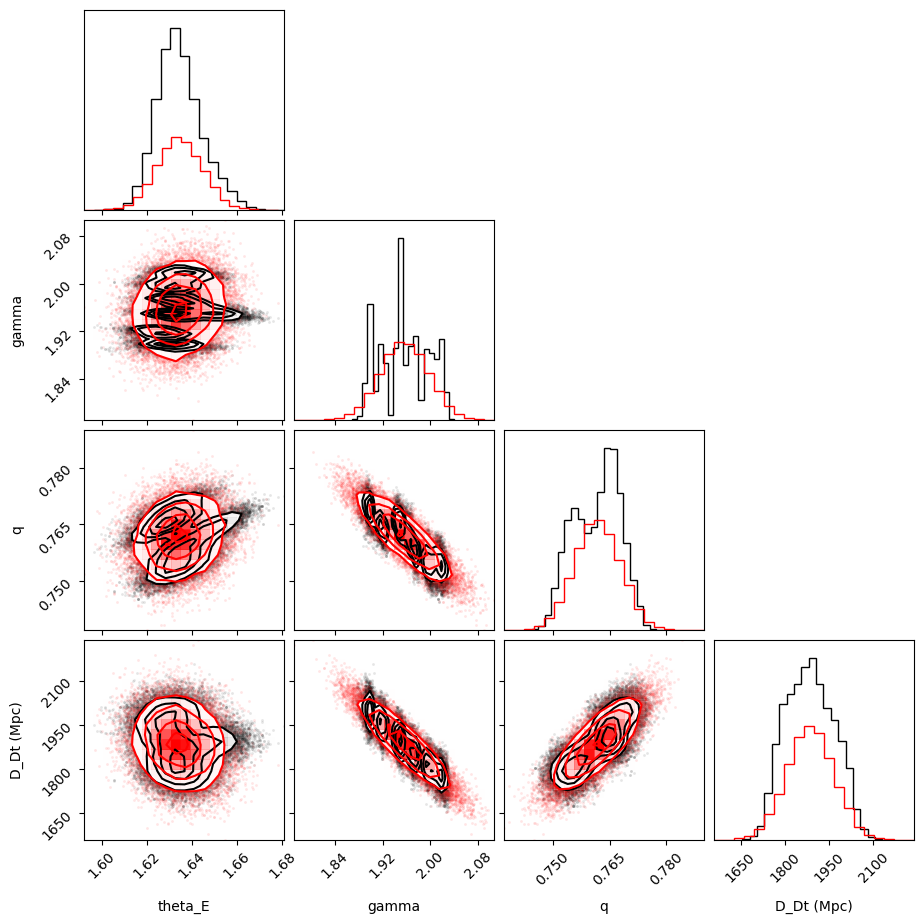

In [9]:
import corner

if model_type == 'powerlaw':
    labels = ['theta_E', 'gamma', 'q', 'D_Dt (Mpc)']
else:
    labels = ['kappa_s', 'r_scale', 'M/L', 'q', 'D_Dt(Mpc)']
    
fig = corner.corner(master_chain, 
                    labels=labels
                   );
corner.corner(multivariate_gaussian_resampled_chain, 
              labels=labels, 
              color='red', 
              fig=fig);

In [10]:
multivariate_gaussian_resampled_chain.shape

(21000, 4)

In [11]:
np.savetxt('../lens_model_chain/{}/multivariate_gaussian_resampled_chain_{}.txt'.format(model_type, model_type), 
           multivariate_gaussian_resampled_chain)